In [1]:
import tensorflow as tf
import numpy as np
import json
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to resize labels
def resize_labels(labels, original_size, new_size):
    # Adjust the label coordinates for the new image size
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels


# Function to convert labels to EfficientDet format
def convert_to_efficientdet_format(labels, image_shape):
    efficientdet_labels = []
    for label in labels:
        # Calculate the coordinates of the upper left and lower right corners
        xmin = (label['x'] - label['radius']) / image_shape[1]
        ymin = (label['y'] - label['radius']) / image_shape[0]
        xmax = (label['x'] + label['radius']) / image_shape[1]
        ymax = (label['y'] + label['radius']) / image_shape[0]
        # EfficientDet format [ymin, xmin, ymax, xmax]
        efficientdet_labels.append([
            max(0, ymin), max(0, xmin), min(1, ymax), min(1, xmax)
        ])
    return efficientdet_labels


# Function to load images and labels
def load_images_and_labels(image_dir, label_dir, original_size=(1024, 1024), new_size=(1024, 1024)):
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.png')]
    label_files = [os.path.join(label_dir, file) for file in sorted(os.listdir(label_dir)) if file.endswith('.json')]
    
    images = []
    all_boxes = []

    for image_file, label_file in zip(image_files, label_files):
        # Load and resize image
        image = load_img(image_file, color_mode='rgb', target_size=new_size)
        # Convert the image to an array and scale the pixel values to [-1, 1]
        image = (img_to_array(image) / 127.5) - 1
        images.append(image)

        # Load labels and adjust for new image size
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size=original_size, new_size=new_size)
        boxes = convert_to_efficientdet_format(resized_json_data, new_size)
        all_boxes.append(boxes)
    
    return np.array(images), all_boxes


# Function to pad labels to a fixed size
def pad_labels(labels, max_boxes=250, pad_value=0):
    padded_labels = []
    for label in labels:
        padded_label = np.zeros((max_boxes, 4), dtype=np.float32) + pad_value
        num_boxes = min(len(label), max_boxes)
        padded_label[:num_boxes] = label[:num_boxes]
        padded_labels.append(padded_label)
    return np.array(padded_labels)

# Function to prepare the dataset
def prepare_dataset(images, boxes, batch_size, num_boxes=250):
    images = tf.constant(images, dtype=tf.float32)
    boxes = pad_labels(boxes, max_boxes=num_boxes)
    boxes = tf.constant(boxes, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, boxes))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 2
image_dir = './TMA_WSI_Padded_PNGs'
label_dir = './TMA_WSI_Labels_updated'
images, boxes = load_images_and_labels(image_dir, label_dir)
# Map this preprocessing function to your dataset




In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image, boxes, figsize=(10, 10)):
    """
    Plots an image with overlaid bounding boxes.

    Args:
    image: The image as a NumPy array.
    boxes: A NumPy array of bounding boxes of shape (N, 4), where N is the number of boxes,
           and each box is defined as (ymin, xmin, ymax, xmax).
    figsize: Size of the figure to display.
    """
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap='gray')  # Assuming the image is grayscale, adjust colormap if not

    img_height, img_width = image.shape[:2]
    for box in boxes:
        if np.all(box == 0):
            continue  # Skip boxes that are all zeros (used for padding)
        ymin, xmin, ymax, xmax = box
        ymin *= img_height
        ymax *= img_height
        xmin *= img_width
        xmax *= img_width
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


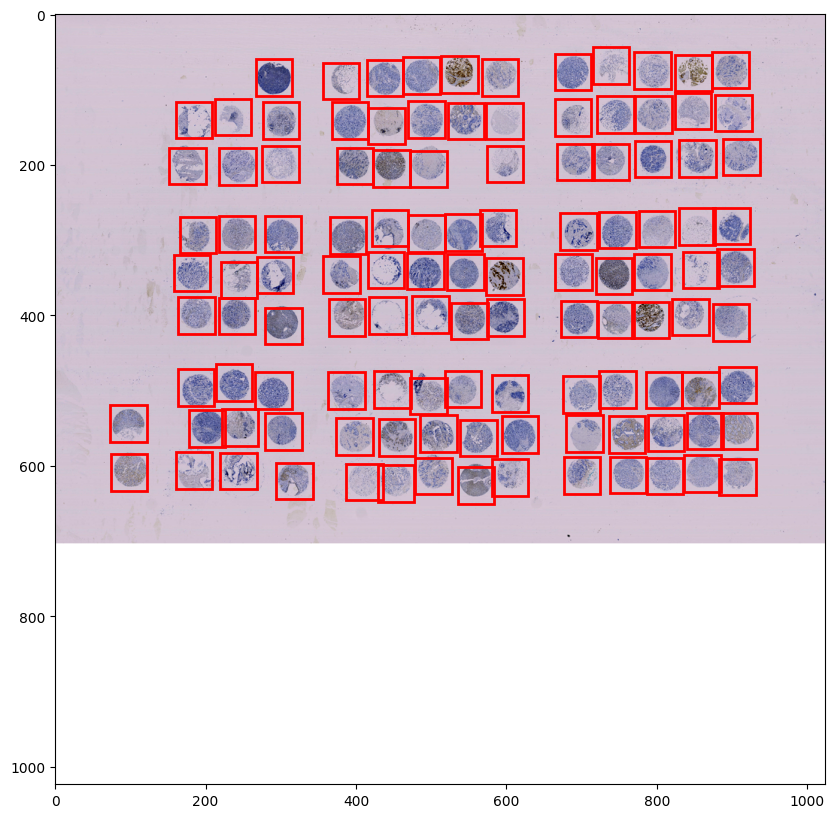

In [8]:
image_number = 30
# Example usage:
# Assuming `images` is your array of images loaded from the dataset and
# `boxes` is the array of bounding boxes for the corresponding images.
# Here we visualize the first image and its boxes.
plot_image_with_boxes(images[image_number], boxes[image_number])

In [9]:
import albumentations as A
import cv2
import json
import os
from skimage import io

# Define the augmentation pipeline
aug = A.Compose([
    A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    # A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(1, 1), translate_percent=None, rotate=None, shear=10, p=0.5),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.4, alpha_coef=0.1, p=0.2)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=True))


# Create directories for augmented images and labels if they don't exist
# aug_image_dir = './augmented_images'
# aug_label_dir = './augmented_labels'
aug_image_dir = './augmented_images'
aug_label_dir = './augmented_labels'
os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

# Paths to your image and label directories
image_dir = './TMA_WSI_Padded_PNGs'
label_dir = './TMA_WSI_Labels_updated'

# Get list of image and label files
image_files = sorted([file for file in os.listdir(image_dir) if file.endswith('.png')])
label_files = sorted([file for file in os.listdir(label_dir) if file.endswith('.json')])

# Make sure we have the same number of image and label files
assert len(image_files) == len(label_files), "The number of image and label files must match"

# Loop over all files to augment and save
for img_file, lbl_file in zip(image_files, label_files):
    # Load the image
    image_path = os.path.join(image_dir, img_file)
    image = io.imread(image_path)

    # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Load the labels
    label_path = os.path.join(label_dir, lbl_file)
    with open(label_path, 'r') as file:
        labels = json.load(file)

    # Extract keypoints and radii from labels
    keypoints = [(label['x'], label['y'], label['radius']) for label in labels]

    # Perform 20 augmentations
    for i in range(20):
        # Apply augmentation
        augmented = aug(image=image, keypoints=keypoints)
        image_aug = augmented['image']
        keypoints_aug = augmented['keypoints']
        
        # Assuming uniform scaling, calculate average scale factor
        # This is a placeholder. In reality, you need to extract the actual scale used in the affine transformation.
        # scale_factor = (0.8 + 1.2) / 2

        # Save the augmented image
        aug_img_path = os.path.join(aug_image_dir, f"{os.path.splitext(img_file)[0]}_aug_{i}.png")
        io.imsave(aug_img_path, image_aug)

        # Convert augmented keypoints back to label format and scale the radii
        labels_aug = [{'x': kp[0], 'y': kp[1], 'radius': kp[2] } for kp in keypoints_aug]

        # Save the augmented labels
        aug_label_path = os.path.join(aug_label_dir, f"{os.path.splitext(lbl_file)[0]}_aug_{i}.json")
        with open(aug_label_path, 'w') as outfile:
            # Convert NumPy types to Python native types for serialization
            labels_aug_python = [{'x': float(kp[0]), 'y': float(kp[1]), 'radius': float(kp[2])} for kp in keypoints_aug]
            json.dump(labels_aug_python, outfile, indent=4)

KeyboardInterrupt: 

In [8]:
import math
import matplotlib.pyplot as plt


def visualize_saved_augmentations(aug_image_dir, aug_label_dir, base_filename, original_img_dir, original_label_dir, num_augmentations=20, per_row=5):
    # Calculate the number of rows needed
    num_rows = math.ceil((num_augmentations + 1) / per_row)
    
    # Set up the figure with a grid of subplots
    fig, axes = plt.subplots(num_rows, per_row, figsize=(20, num_rows * 4))

    # Flatten axes array for easy iteration, in case of a single row
    axes = axes.flatten()
    
    # Display the original image and labels
    original_image_path = os.path.join(original_img_dir, base_filename + '.png')
    original_label_path = os.path.join(original_label_dir, base_filename + '.json')
    original_image = io.imread(original_image_path)
    with open(original_label_path, 'r') as file:
        labels_original = json.load(file)

    axes[0].imshow(original_image)
    for label in labels_original:
        axes[0].scatter(label['x'], label['y'], c='red', s=label['radius'])
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Hide axes ticks

    # Plot each augmented image and its labels
    for i in range(num_augmentations):
        aug_img_filename = f"{base_filename}_aug_{i}.png"
        aug_label_filename = f"{base_filename}_aug_{i}.json"
        aug_image_path = os.path.join(aug_image_dir, aug_img_filename)
        aug_label_path = os.path.join(aug_label_dir, aug_label_filename)
        
        image_aug = io.imread(aug_image_path)
        with open(aug_label_path, 'r') as file:
            labels_aug = json.load(file)

        axes[i + 1].imshow(image_aug)
        for label in labels_aug:
            axes[i + 1].scatter(label['x'], label['y'], c='red', s=label['radius'])
        axes[i + 1].set_title(f'Augmentation {i+1}')
        axes[i + 1].axis('off')  # Hide axes ticks

    # Hide any unused subplots if the number of augmentations + 1 is not a multiple of per_row
    for j in range(num_augmentations + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

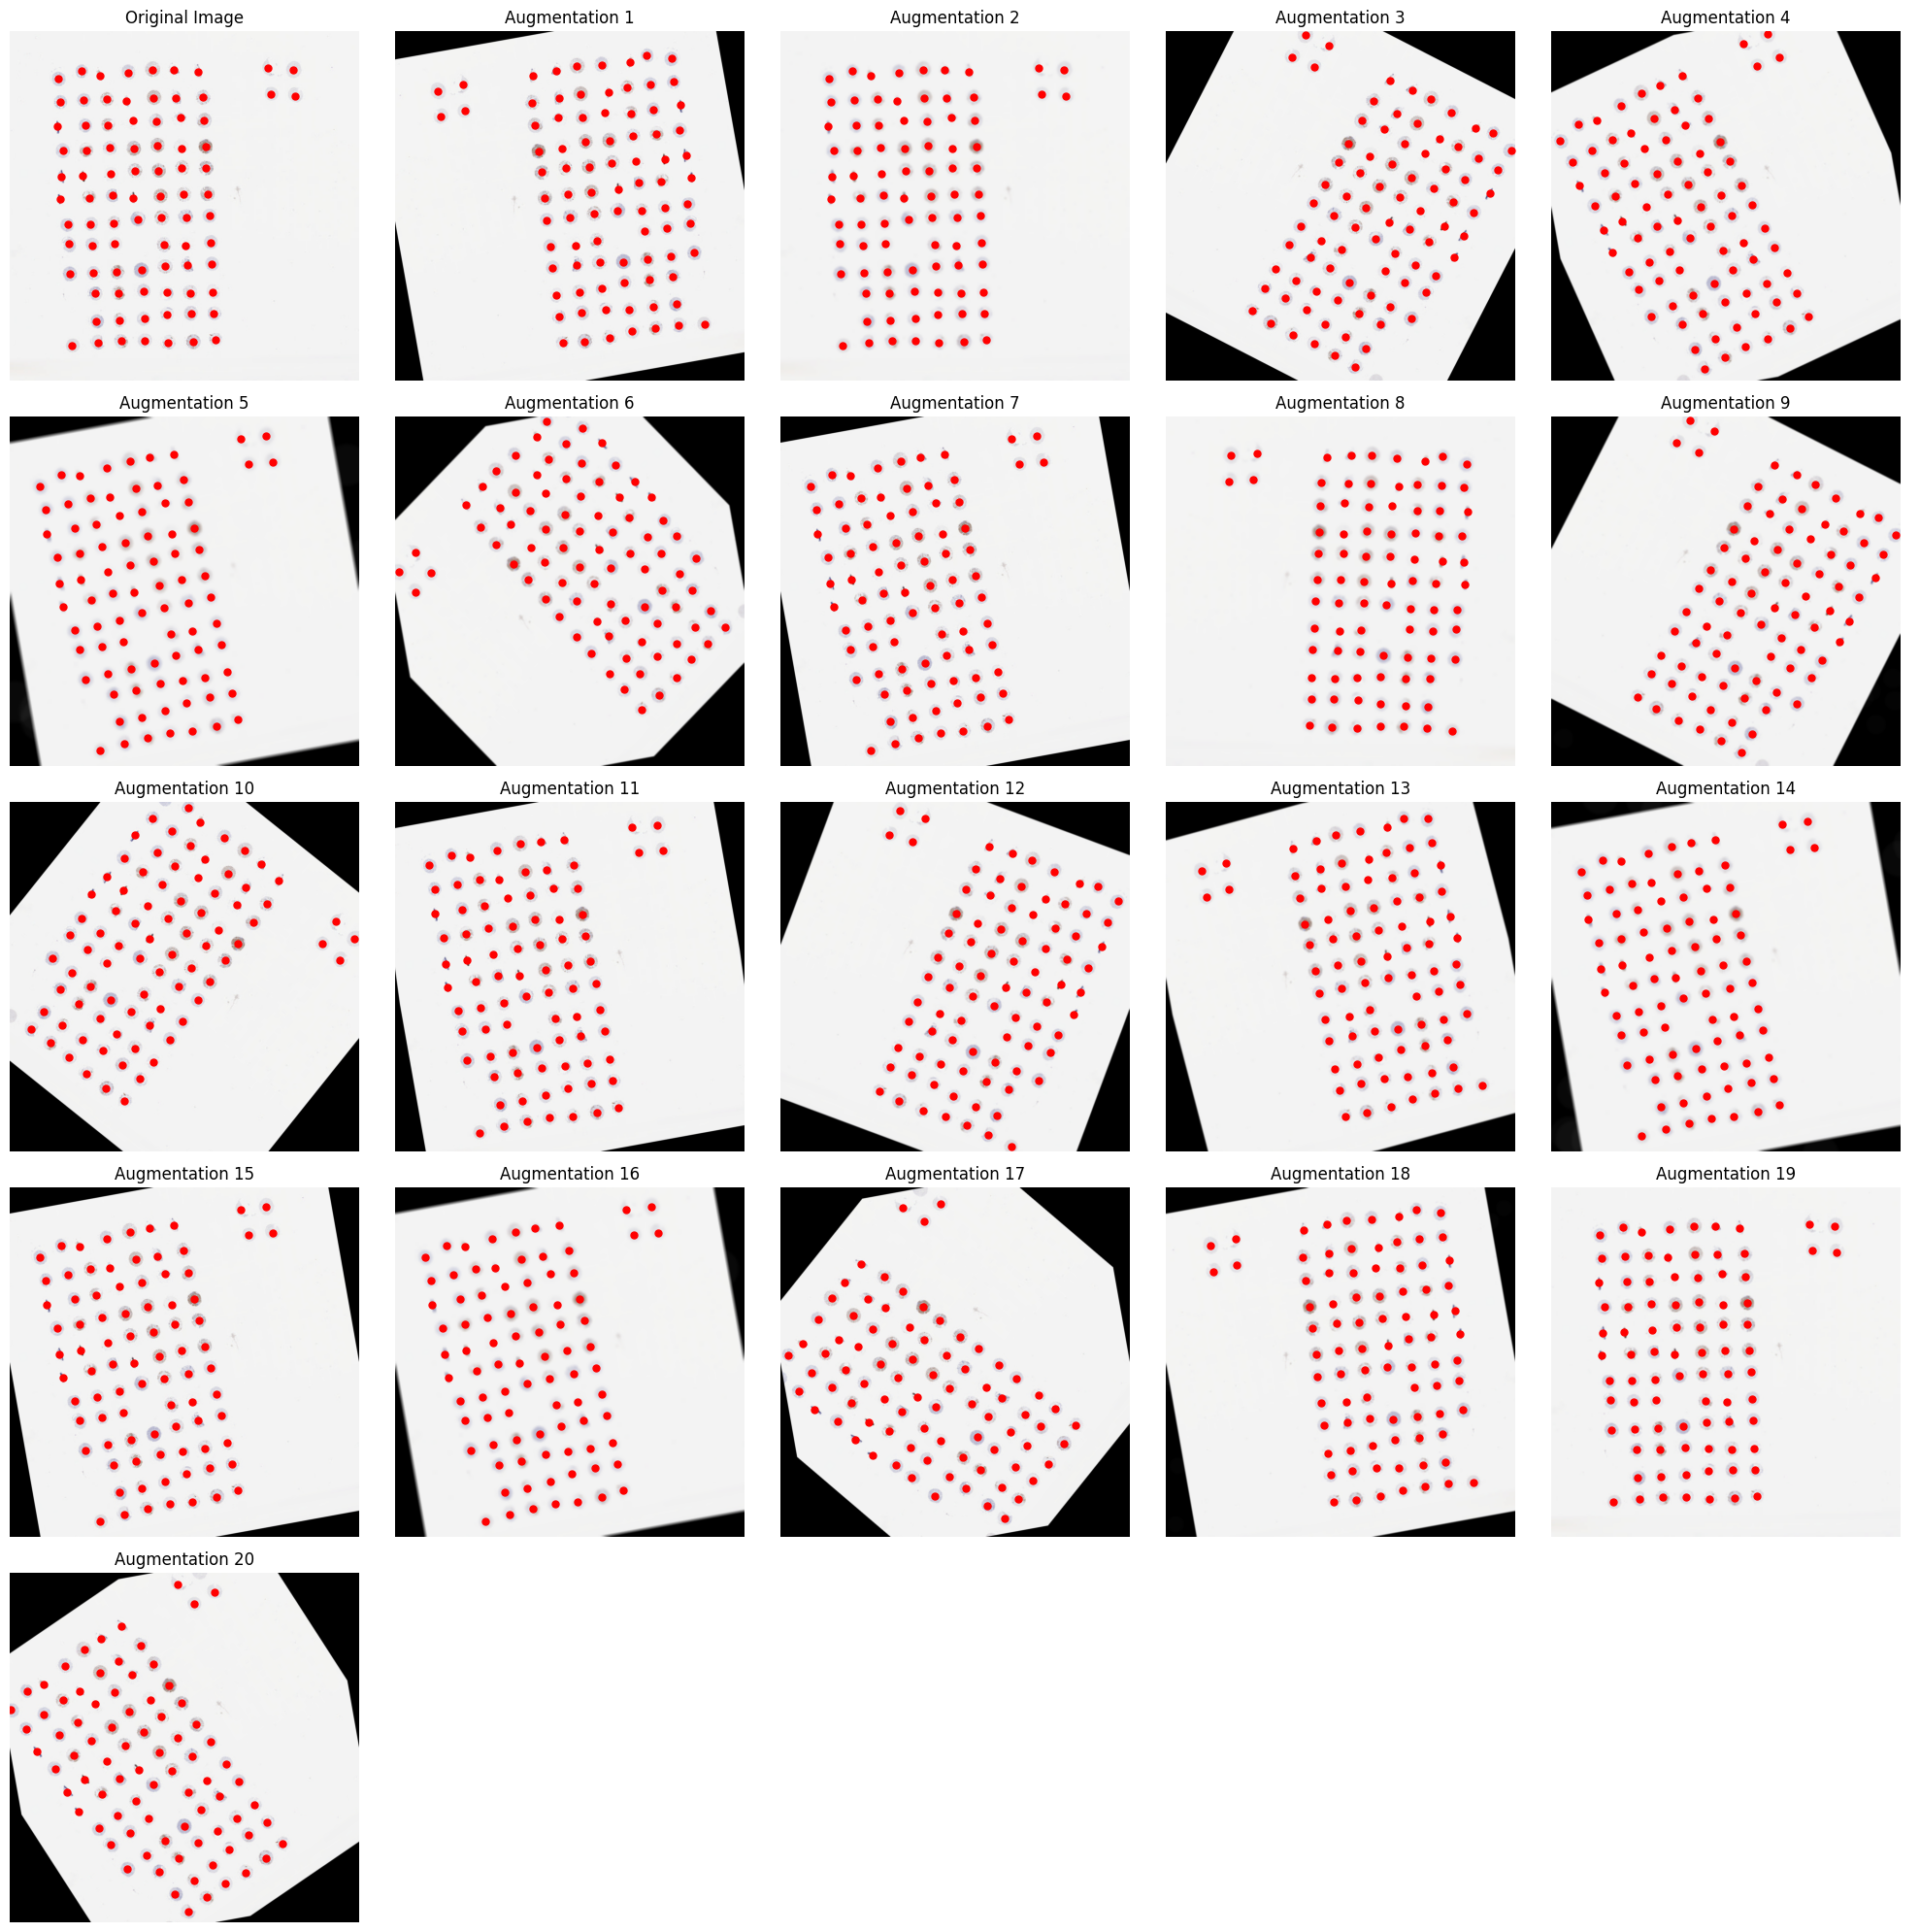

In [13]:

# Example usage:
aug_image_dir = './augmented_images' # Directory where augmented images are stored
aug_label_dir = './augmented_labels' # Directory where augmented labels are stored
org_image_dir = './TMA_WSI_Padded_PNGs'  # Directory where original images are stored
org_label_dir = './TMA_WSI_Labels_updated'  # Directory where original labels are stored
base_filename = '60'  # Base filename without extension or augmentation index

visualize_saved_augmentations(aug_image_dir, aug_label_dir, base_filename, org_image_dir, org_label_dir)
